## Display and Create RGBa GeoTIFF
 - Create the colormap
 - Get the RGB band from this colormap
 - Create a 3 bands (RGB geotiff) from the 1band GeoTIFF 

Worldwide Glaciers project - IGE - JB Barré - 11/05/2021

In [1]:
from osgeo import gdal,osr
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from cmcrameri import cm


In [2]:
# Change the working directory
os.chdir('D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\')
mypath = os.getcwd()
out_folder = 'D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\'
# Get the content of the folder
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

in_file='Mosaic_HIMALAYA_BHUTAN_S2L8_2017-2018_2020September22_vo_AdaptFilter_3857.tif'


In [11]:
# read GeoTIFF source
src = gdal.Open(in_file, gdal.GA_ReadOnly) 

# Note GetRasterBand() takes band no. starting from 1 not 0
band = src.GetRasterBand(1)
arr = np.nan_to_num(band.ReadAsArray())

# Scale the velocities by the log of the data.
d = np.log(np.clip(arr, 1, 3000))
# Rescaling (min-max normalization) - 255 for RGB ??
scaled_ds = (255*(d - np.amin(d))/np.ptp(d)).astype(np.uint8)


In [12]:
print(d.shape)
print(np.ptp(arr))
print(np.min(scaled_ds))

(8152, 10103)
1483.4064
0


## Plot scaled GeoTIFF

In [5]:
# Construct a colormap with log scale 
# designed by Terry Haran, NSIDC, April 2018. 
# Construct an RGB table using a log scale between 1 and 3000 m/year.
vel = np.exp(np.linspace(np.log(1), np.log(3000), num=256)) 
hue = np.arange(256) / 255.0 
sat = np.clip(1. / 3 + vel / 187.5, 0, 1) 
value = np.zeros(256) + 0.75 
hsv = np.stack((hue, sat, value), axis=1) 
rgb = colors.hsv_to_rgb(hsv) 
# Be sure the first color (the background) is white
rgb[0, :] = 1
# Create the colormap 
cmap = colors.ListedColormap(rgb, name='velocity')
print(type(cmap))

<class 'matplotlib.colors.ListedColormap'>


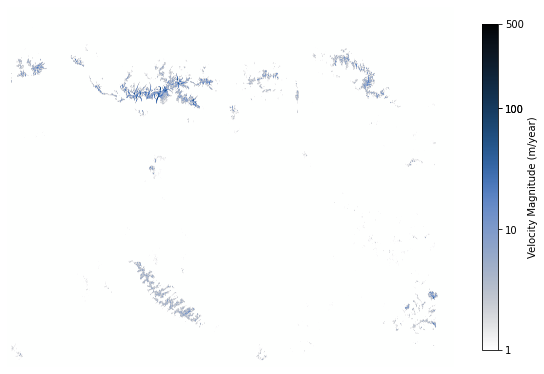

In [27]:
plt.figure(figsize=(10,12))
fig = plt.imshow(scaled_ds, origin='lower', cmap=cm.oslo_r)
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
tickval = [1, 10, 100, 100, 500]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5)
cb.set_label('Velocity Magnitude (m/year)')
cb.ax.set_yticklabels(tickval)
plt.show()

## From 1 band GeoTIFF to RGB GeoTIFF

In [9]:
# apply the colormap to the scaled data
#rgb_func = lambda t : cmap(t)
#rgb_ds =np.array([rgb_func(xi) for xi in scaled_ds])
rgb_ds =  cmap(scaled_ds)
rgb_ds.shape
rgb_ds[:,:,3]

array([1., 1., 1., ..., 1., 1., 1.])

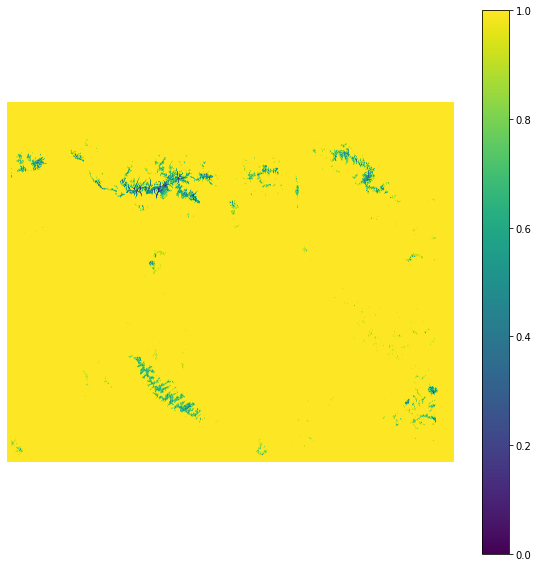

In [8]:
plt.figure(figsize=(10,10))
fig = plt.imshow(rgb_ds[:,:,0], origin='lower')
# plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
cb = plt.colorbar(fig)
plt.show()

In [10]:
# rescale RGB values from [0,1] to [0,255]
data_array_scaled = np.interp(rgb_ds,(0, 1), (0, 255))

In [8]:
# Creates a copy of a 3-band raster with values from array'''
# GeoTIFF creation options : https://gdal.org/drivers/raster/gtiff.html

# Destination file name 
dest_name = 'D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\Mosaic_HIMALAYA_BHUTAN_S2L8_2017-2018_2020September22_vo_AdaptFilter_3857_rgb.tif'

# info from source
geotransform = src.GetGeoTransform ()
originX = geotransform[0]
originY = geotransform[3]
pixelWidth = geotransform[1]
pixelHeight = geotransform[5]
bands = data_array_scaled.shape[2]-1
rows = src.RasterXSize
cols = src.RasterYSize

# Get geotiff driver
driver = gdal.GetDriverByName('GTiff')
options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF','COMPRESS=LZW','PREDICTOR=2','GDAL_TIFF_INTERNAL_MASK=YES']

# Create new raster
dest = driver.Create(dest_name,rows,cols, bands, eType=gdal.GDT_Byte,options=options)
dest.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

# Set metadata.SetGeoTransform(src.GetGeoTransform())
dest.GetRasterBand(1).WriteArray(np.around(data_array_scaled[:,:,0]))
dest.GetRasterBand(1).SetNoDataValue(255)
dest.GetRasterBand(2).WriteArray(np.around(data_array_scaled[:,:,1]))
dest.GetRasterBand(2).SetNoDataValue(255)
dest.GetRasterBand(3).WriteArray(np.around(data_array_scaled[:,:,2]))
dest.GetRasterBand(3).SetNoDataValue(255)
# loop through bands and write new values
#or bix in range(3):
#    destb = dest.GetRasterBand(bix+1)
#    #Write array
#    destb.WriteArray(rgb_data[:,:,bix])

destSRS = osr.SpatialReference()
destSRS.ImportFromEPSG(3857)
dest.SetProjection(destSRS.ExportToWkt())

# Close datasets
#src = None
dest = None
rb = None


In [14]:
# add an alpha band to the RGB for transparent background in Mapbox
src_file ='D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\Mosaic_HIMALAYA_BHUTAN_S2L8_2017-2018_2020September22_vo_AdaptFilter_3857_rgb.tif'
dest_file ='D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\Mosaic_HIMALAYA_BHUTAN_S2L8_2017-2018_2020September22_vo_AdaptFilter_3857_rgba.tif'

options = gdal.WarpOptions(format='GTiff', srcNodata=255, dstAlpha=True)
dest = gdal.Warp(dest_file, src_file, options=options)
dest = None

In [38]:
proj = osr.SpatialReference(wkt=src.GetProjection())
print(proj.GetAttrValue('AUTHORITY',1))

3857


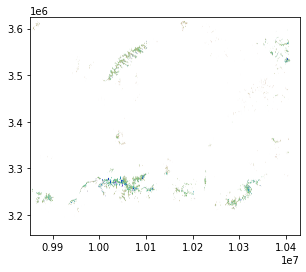

<AxesSubplot:>

In [45]:

fp = 'D:\\3_DataViz\\2_glaciers\\1_data_himalaya\\data_3857\\Mosaic_HIMALAYA_BHUTAN_S2L8_2017-2018_2020September22_vo_AdaptFilter_3857_rgb.tif'

img = rasterio.open(fp)
show(img)